# Part 1: Baseline RAG
## Building a Simple Retrieval-Augmented Generation System

In this notebook, we'll build a basic RAG system for e-commerce customer support.

**What we'll cover:**
1. Document chunking
2. Embedding generation
3. FAISS vector indexing
4. Retrieval pipeline
5. Response generation
6. **Limitations** - Why basic RAG isn't enough

## Setup & Imports

In [2]:
# Install required packages (run once)
# !pip install openai faiss-cpu numpy python-dotenv

In [1]:
import os
from typing import List, Dict
import numpy as np
import httpx
from openai import OpenAI
import faiss
from IPython.display import display, Markdown, HTML

# Set your OpenAI API key
# Option 1: Set as environment variable
# export OPENAI_API_KEY='your-key'

# Option 2: Load from .env file
from dotenv import load_dotenv
load_dotenv()

# Option 3: Set directly (not recommended for production)
# os.environ["OPENAI_API_KEY"] = "sk-your-key-here"

# ⚠️ SSL BYPASS FOR CORPORATE NETWORKS (DEMO ONLY - NOT FOR PRODUCTION)
# This disables SSL certificate verification to work with corporate proxies
# For production, configure proper SSL certificates instead
http_client = httpx.Client(verify=False)
# http_client = httpx.Client(verify=True)  # Use this line in production

# Initialize OpenAI client
client = OpenAI(
    api_key=os.getenv("OPENAI_API_KEY"),
    http_client=http_client  # SSL bypass for corporate networks
)

print("✅ Setup complete!")
print("⚠️  SSL verification disabled (for demo purposes only)")

✅ Setup complete!
⚠️  SSL verification disabled (for demo purposes only)


## 1. Knowledge Base

Our e-commerce company has three policy documents that customer support needs to reference:

In [2]:
KNOWLEDGE_BASE = {
    "return_policy.md": """
# Return Policy
## Eligibility
- Items can be returned within 30 days of delivery
- Items must be in original condition with tags attached
- Damaged or defective items: Full refund
- Change of mind: Refund minus 15% restocking fee

## Process
1. Submit return request with order number
2. Print return label (provided via email)
3. Ship item within 5 business days
4. Refund processed within 7-10 business days after receipt

## Non-returnable Items
- Perishable goods
- Personal care items
- Digital downloads
""",
    "shipping_policy.md": """
# Shipping Policy

## Delivery Times
- Standard shipping: 5-7 business days
- Express shipping: 2-3 business days
- International: 10-15 business days

## Shipping Costs
- Orders over $50: Free standard shipping
- Orders under $50: $5.99 standard, $15.99 express
- International: Calculated at checkout

## Tracking
- Tracking number sent via email within 24 hours
- Track on our website or carrier website

## Regions
- We ship to USA, Canada, UK, Australia
- Some remote areas may have extended delivery times
""",
    "product_info.md": """
# Product Information

## Product Care
- Machine wash cold, tumble dry low
- Do not bleach or iron directly on prints
- Check individual product labels for specific care

## Sizing
- Refer to size chart on product pages
- If between sizes, we recommend sizing up
- Contact support for personalized sizing help

## Materials
- All cotton products are 100% organic cotton
- Synthetic blends clearly labeled
- Hypoallergenic materials available
"""
}

print(f"📚 Knowledge base loaded: {len(KNOWLEDGE_BASE)} documents")
for doc_name in KNOWLEDGE_BASE.keys():
    print(f"  - {doc_name}")

📚 Knowledge base loaded: 3 documents
  - return_policy.md
  - shipping_policy.md
  - product_info.md


## 2. Document Chunking

We split documents into smaller chunks to improve retrieval precision.

**Why chunk?**
- Better semantic matching (specific sections vs entire docs)
- Fits within LLM context windows
- More precise citations

In [3]:
def chunk_documents(chunk_size: int = 500, overlap: int = 50) -> List[Dict]:
    """Split documents into overlapping chunks."""
    chunks = []
    
    for doc_name, content in KNOWLEDGE_BASE.items():
        # Simple sentence-based chunking
        sentences = content.split('\n')
        # print(sentences)
        current_chunk = ""
        # This keeps appending lines until: The chunk would exceed chunk_size = 500
        for sentence in sentences:
            if len(current_chunk) + len(sentence) < chunk_size:
                current_chunk += sentence + "\n"
                # print(current_chunk)
                # print("="*60)
            else:
                # When it would exceed the size:
                # A chunk is saved with:
                # text → the chunk content
                # source → which document it came from
                # chunk_id → unique ID
                # Then it starts a new chunk.
                if current_chunk.strip(): # Safety check to avoid creating empty or useless chunks.
                    chunks.append({
                        "text": current_chunk.strip(),
                        "source": doc_name,
                        "chunk_id": len(chunks)
                    })
                # This line is resetting the chunk and starting a new one with the current sentence.
                # So this happens when adding sentence would exceed the chunk size.
                current_chunk = sentence + "\n"
                # print(current_chunk)
                # print("="*60)
        
        # Add remaining chunk
        # If there is anything left in current_chunk, save it.
        if current_chunk.strip():
            # print(current_chunk)
            # print("="*60)
            chunks.append({
                "text": current_chunk.strip(),
                "source": doc_name,
                "chunk_id": len(chunks)
            })
    
    return chunks

# Create chunks
chunks = chunk_documents()
print(type(chunks))
print(type(chunks[0]))
print(f"📄 Created {len(chunks)} chunks\n")

# Show example chunk
print("Example chunk:")
print("="*60)
# print(chunks[0])
# print(chunks)
print(f"Source: {chunks[0]['source']}")
print(f"Chunk ID: {chunks[0]['chunk_id']}")
print(f"Text:\n{chunks[0]['text'][:200]}...")

<class 'list'>
<class 'dict'>
📄 Created 5 chunks

Example chunk:
Source: return_policy.md
Chunk ID: 0
Text:
# Return Policy
## Eligibility
- Items can be returned within 30 days of delivery
- Items must be in original condition with tags attached
- Damaged or defective items: Full refund
- Change of mind: R...


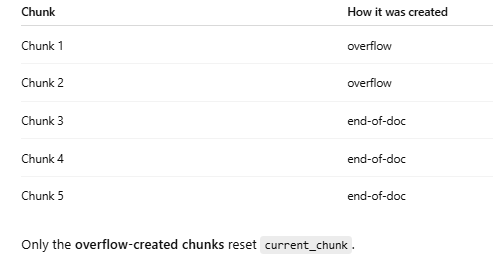

## 3. Generate Embeddings

Convert text chunks into dense vectors using OpenAI's embedding model.

**Model:** `text-embedding-3-large` (3072 dimensions)  

- Larger dimension → more capacity to encode nuance
- Smaller dimension → faster, cheaper, less memory, but less expressive

In [7]:
def embed_text(text: str) -> np.ndarray:
    """Generate embedding for text using OpenAI."""
    response = client.embeddings.create(
        input=text,
        model="text-embedding-3-large"
    )
    # print(response)
    # print(type(response))
    # print(type(response.data[0].embedding))
    return np.array(response.data[0].embedding, dtype=np.float32)

# Test with a sample
sample_text = "What is your return policy?"
sample_embedding = embed_text(sample_text)

print(f"✅ Embedding generated")
print(f"   Text: '{sample_text}'")
print(f"   Dimensions: {sample_embedding.shape[0]}")
print(f"   Sample values: {sample_embedding[:5]}")

✅ Embedding generated
   Text: 'What is your return policy?'
   Dimensions: 3072
   Sample values: [-0.01740943 -0.03211692 -0.0162813   0.02196374 -0.01867684]


In [10]:
for i, chunk in enumerate(chunks):
    print(i)
    print(chunk)

0
{'text': '# Return Policy\n## Eligibility\n- Items can be returned within 30 days of delivery\n- Items must be in original condition with tags attached\n- Damaged or defective items: Full refund\n- Change of mind: Refund minus 15% restocking fee\n\n## Process\n1. Submit return request with order number\n2. Print return label (provided via email)\n3. Ship item within 5 business days\n4. Refund processed within 7-10 business days after receipt\n\n## Non-returnable Items\n- Perishable goods\n- Personal care items', 'source': 'return_policy.md', 'chunk_id': 0}
1
{'text': '- Digital downloads', 'source': 'return_policy.md', 'chunk_id': 1}
2
{'text': '# Shipping Policy\n\n## Delivery Times\n- Standard shipping: 5-7 business days\n- Express shipping: 2-3 business days\n- International: 10-15 business days\n\n## Shipping Costs\n- Orders over $50: Free standard shipping\n- Orders under $50: $5.99 standard, $15.99 express\n- International: Calculated at checkout\n\n## Tracking\n- Tracking numb

In [11]:
# Generate embeddings for all chunks
print("🔢 Generating embeddings for all chunks...")

embeddings = []
for i, chunk in enumerate(chunks):
    # Print progress every 5 chunks
    if i % 5 == 0:
        print(f"   Processing chunk {i+1}/{len(chunks)}")
    embedding = embed_text(chunk["text"])
    embeddings.append(embedding)

embeddings_matrix = np.vstack(embeddings) # Convert list of embeddings to a 2D numpy array
# It stacks arrays on top of each other row-by-row to make a single 2-D array.
print(f"\n✅ Embeddings generated: {embeddings_matrix.shape}")

🔢 Generating embeddings for all chunks...
   Processing chunk 1/5

✅ Embeddings generated: (5, 3072)


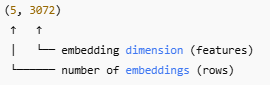

## 4. Build FAISS Index

Create a vector index for fast similarity search.

**FAISS** (Facebook AI Similarity Search) is production-grade and handles millions of vectors efficiently.

In [ ]:
# Create FAISS index
dimension = embeddings_matrix.shape[1]
index = faiss.IndexFlatL2(dimension)
# index = faiss.IndexFlatL2(3072)
# A flat (exact) index that uses L2 (Euclidean) distance
# Index = A FAISS data structure for storing and searching vectors.
# Flat = No compression, No clustering, No approximation, Stores all vectors exactly
# L2 (Euclidean) distance to measure similarity between vectors
# Lower distance = more similar

# What IndexFlatL2 does is stores vectors in RAM
# Compares your query vector to every stored vector
# Returns the closest matches by Euclidean distance

index.add(embeddings_matrix)

print(f"✅ FAISS index built")
print(f"   Dimension: {dimension}")
# Total vectors = number of rows in embeddings_matrix
print(f"   Total vectors: {index.ntotal}")
print(f"   Index type: L2 (Euclidean distance)")

✅ FAISS index built
   Dimension: 3072
   Total vectors: 5
   Index type: L2 (Euclidean distance)


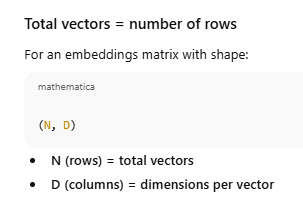

## 5. Retrieval Function

Given a query, find the most relevant chunks from our knowledge base.

In [ ]:
def retrieve(query: str, k: int = 3) -> List[Dict]:
    """Retrieve top-k relevant chunks for a query."""
    # Embed the query
    # reshape(1, -1) makes it a 2D array with 1 row and appropriate number of columns
    # (3072,)  →  (1, 3072)
    # 1 query vector with 3072 dimensions
    query_embedding = embed_text(query).reshape(1, -1)
    
    # Search the index
    distances, indices = index.search(query_embedding, k)
    # print(f"distances: {distances}")
    # print(f"indices: {indices}")

    # print(f"Inner distances: {distances[0]}")
    # print(f"Inner indices: {indices[0]}")
    # FAISS returns: closest to farthest vectors you can see from below list
    # distances: [[0.8520924 1.2390496 1.4010513]]
    # indices: [[0 2 4]]
    # Closest vector → chunks[0]
    # Second closest → chunks[2]
    # Third closest → chunks[4]
    
    # Prepare results
    results = []
    for idx, distance in zip(indices[0], distances[0]):
        # zip([0, 2, 4], [0.8520924 1.2390496 1.4010513])
        # Create pairs of (index, distance)
        # (0, 0.8520924)
        # (2, 1.2390496)
        # (4, 1.4010513)
        # Each pair = (which chunk, how close it is)
        # Distance = The distance is from the query vector to each stored chunk vector in the FAISS index.
        # Distances can be greater than 1.0 because FAISS is returning raw L2 (Euclidean) distances,
        # which are unbounded.
        # They are not similarity scores and not normalized.
        results.append({
            **chunks[idx], # Take all key–value pairs from chunks[idx] and insert them into this new dictionary.
            "similarity_score": float(1 / (1 + distance))  # Convert distance to similarity
        })
    
    return results

# Test retrieval
test_query = "What is your return policy?"
results = retrieve(test_query, k=3)

print(f"🔍 Query: '{test_query}'\n")
print(f"🔍 Type Of Results: '{type(results)}'\n")
print(f"🔍 Inside Type Of Results: '{type(results[0])}'\n")
print(f"📄 Top {len(results)} results:\n")

# 1 tells enumerate to start counting from 1 instead of 0.
for i, result in enumerate(results, 1):
    print(result)
    print(f"{i}. Source: {result['source']} (score: {result['similarity_score']:.3f})")
    print(f"   Text: {result['text'][:100]}...")
    print()

🔍 Query: 'What is your return policy?'

🔍 Type Of Results: '<class 'list'>'

🔍 Inside Type Of Results: '<class 'dict'>'

📄 Top 3 results:

{'text': '# Return Policy\n## Eligibility\n- Items can be returned within 30 days of delivery\n- Items must be in original condition with tags attached\n- Damaged or defective items: Full refund\n- Change of mind: Refund minus 15% restocking fee\n\n## Process\n1. Submit return request with order number\n2. Print return label (provided via email)\n3. Ship item within 5 business days\n4. Refund processed within 7-10 business days after receipt\n\n## Non-returnable Items\n- Perishable goods\n- Personal care items', 'source': 'return_policy.md', 'chunk_id': 0, 'similarity_score': 0.5398845672607422}
1. Source: return_policy.md (score: 0.540)
   Text: # Return Policy
## Eligibility
- Items can be returned within 30 days of delivery
- Items must be in...

{'text': '# Shipping Policy\n\n## Delivery Times\n- Standard shipping: 5-7 business days\n- Express s

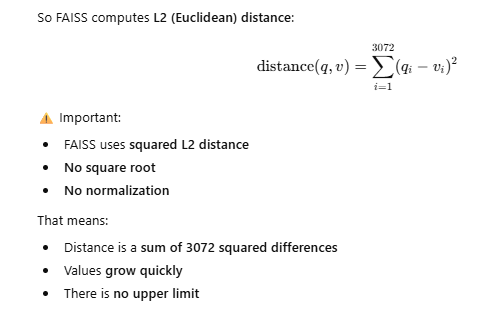

## 6. Response Generation

Use retrieved context + LLM to generate the final answer.

In [55]:
def generate_response(query: str, context_chunks: List[Dict]) -> str:
    """Generate response using retrieved context."""
    # Build context from chunks
    context = "\n\n".join([
        f"[Source: {chunk['source']}]\n{chunk['text']}"
        for chunk in context_chunks
    ])
    # print(context)
    # Create prompt
    prompt = f"""You are a helpful customer support agent for an e-commerce company.
Answer the customer's question using ONLY the information provided in the context below.
If the context doesn't contain enough information, say so.

Context:
{context}

Customer Question: {query}

Answer:"""
    
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "You are a helpful customer support agent."},
            {"role": "user", "content": prompt}
        ],
        temperature = 0.3
    )
    
    return response.choices[0].message.content

## 7. Complete RAG Pipeline

Putting it all together: Retrieve → Generate

In [56]:
def rag_query(user_query: str, k: int = 3):
    """Full RAG pipeline: retrieve + generate."""
    print(f"\n{'='*80}")
    print(f"🔍 Query: {user_query}")
    print("="*80)
    
    # Retrieve
    print("\n📄 Retrieving relevant context...")
    retrieved_chunks = retrieve(user_query, k=k)
    # print(retrieved_chunks)
    
    print(f"   Found {len(retrieved_chunks)} relevant chunks:")
    for chunk in retrieved_chunks:
        print(f"   - {chunk['source']} (score: {chunk['similarity_score']:.3f})")
    
    # Generate
    print("\n🤖 Generating response...")
    response = generate_response(user_query, retrieved_chunks)
    
    print(f"\n💬 Response:")
    print("-"*80)
    display(Markdown(response))
    print("-"*80)
    
    return {
        "query": user_query,
        "response": response,
        "sources": [chunk['source'] for chunk in retrieved_chunks],
        "retrieved_chunks": retrieved_chunks
    }

## 8. Demo: Simple Questions ✅

Let's test with straightforward policy questions where RAG works well.

In [ ]:
# Query 1: Return policy
result1 = rag_query("What is your return policy?")


🔍 Query: What is your return policy?

📄 Retrieving relevant context...
   Found 3 relevant chunks:
   - return_policy.md (score: 0.540)
   - shipping_policy.md (score: 0.447)
   - product_info.md (score: 0.416)

🤖 Generating response...

💬 Response:
--------------------------------------------------------------------------------


Our return policy allows items to be returned within 30 days of delivery, provided they are in original condition with tags attached. For damaged or defective items, you will receive a full refund. If you are returning an item due to a change of mind, a refund will be issued minus a 15% restocking fee. 

To initiate a return, you need to submit a return request with your order number, print the return label provided via email, and ship the item within 5 business days. Refunds are processed within 7-10 business days after we receive the returned item. Please note that perishable goods and personal care items are non-returnable.

--------------------------------------------------------------------------------


In [54]:
result1 = rag_query("What is your return policy?")
print(result1)


🔍 Query: What is your return policy?

📄 Retrieving relevant context...
   Found 3 relevant chunks:
   - return_policy.md (score: 0.540)
   - shipping_policy.md (score: 0.447)
   - product_info.md (score: 0.416)

🤖 Generating response...

💬 Response:
--------------------------------------------------------------------------------


Our return policy allows items to be returned within 30 days of delivery, provided they are in original condition with tags attached. For damaged or defective items, a full refund is issued. If you are returning an item due to a change of mind, a refund will be processed minus a 15% restocking fee. 

To initiate a return, you need to submit a return request with your order number, print the return label provided via email, and ship the item within 5 business days. Refunds are processed within 7-10 business days after we receive the returned item. Please note that perishable goods and personal care items are non-returnable.

--------------------------------------------------------------------------------
{'query': 'What is your return policy?', 'response': 'Our return policy allows items to be returned within 30 days of delivery, provided they are in original condition with tags attached. For damaged or defective items, a full refund is issued. If you are returning an item due to a change of mind, a refund will be processed minus a 15% restocking fee. \n\nTo initiate a return, you need to submit a return request with your order number, print the return label provided via email, and ship the item within 5 business days. Refunds are processed within 7-10 business days after we receive the returned item. Please note that perishable goods and personal care items are non-returnable.', 'sources': ['return_policy.md', 'shipping_policy.md', 'product_info.md'], 'retrieved_chunks': [{'text': '# Return Policy\n## Eligibility\n- Items can be returned within 30 days of delivery\n- Items must be in original condition wi

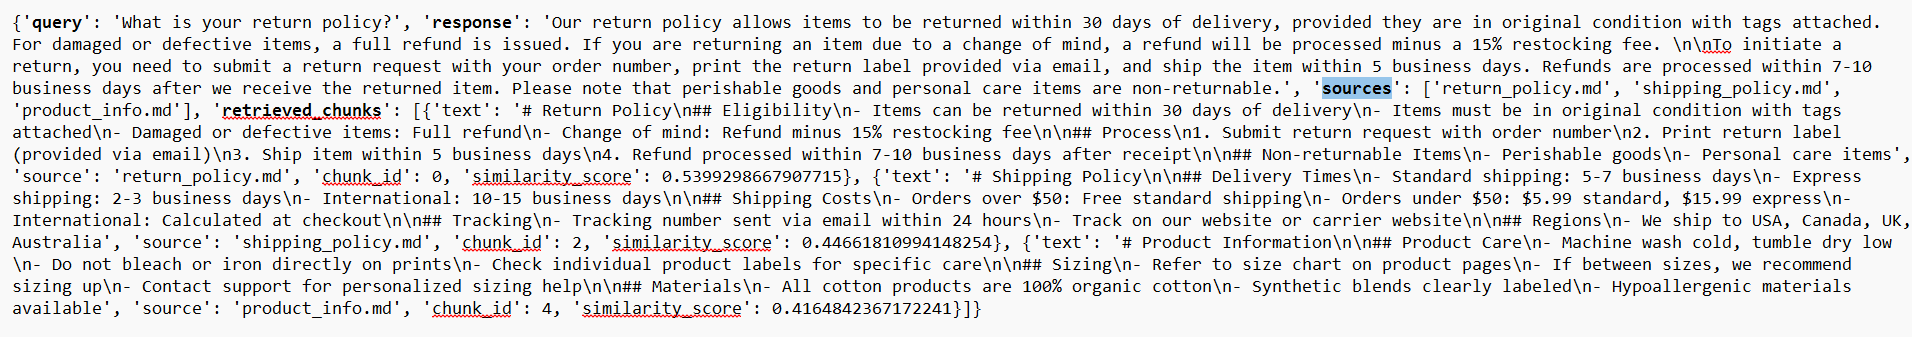

In [58]:
# Query 2: Shipping times
result2 = rag_query("How long does shipping take?")


🔍 Query: How long does shipping take?

📄 Retrieving relevant context...
   Found 3 relevant chunks:
   - shipping_policy.md (score: 0.501)
   - shipping_policy.md (score: 0.452)
   - return_policy.md (score: 0.417)

🤖 Generating response...

💬 Response:
--------------------------------------------------------------------------------


Shipping times vary based on the shipping method chosen: 

- Standard shipping takes 5-7 business days.
- Express shipping takes 2-3 business days.
- International shipping takes 10-15 business days. 

Please note that some remote areas may have extended delivery times.

--------------------------------------------------------------------------------


In [59]:
# Query 3: Damaged items
result3 = rag_query("Can I return a damaged item?")


🔍 Query: Can I return a damaged item?

📄 Retrieving relevant context...
   Found 3 relevant chunks:
   - return_policy.md (score: 0.471)
   - shipping_policy.md (score: 0.391)
   - shipping_policy.md (score: 0.389)

🤖 Generating response...

💬 Response:
--------------------------------------------------------------------------------


Yes, you can return a damaged item for a full refund.

--------------------------------------------------------------------------------


## 9. Demo: Action Required ❌

Now let's see where baseline RAG **fails** - when the customer needs us to actually DO something.

In [60]:
# Query 4: Process return (requires action!)
result4 = rag_query("I want to return order #12345 because it arrived damaged. Can you process this?")


🔍 Query: I want to return order #12345 because it arrived damaged. Can you process this?

📄 Retrieving relevant context...
   Found 3 relevant chunks:
   - return_policy.md (score: 0.453)
   - shipping_policy.md (score: 0.393)
   - product_info.md (score: 0.382)

🤖 Generating response...

💬 Response:
--------------------------------------------------------------------------------


Yes, you can return order #12345 because it arrived damaged. You are eligible for a full refund. Please submit your return request with your order number, and follow the return process outlined in our return policy.

--------------------------------------------------------------------------------


## ⚠️ Limitation Identified!

**What just happened?**

The baseline RAG system:
- ✅ Retrieved the return policy (good!)
- ✅ Told the customer what the policy says (accurate!)
- ❌ **Did NOT check if order #12345 exists**
- ❌ **Did NOT verify if the item is eligible for return**
- ❌ **Did NOT calculate the refund amount**
- ❌ **Did NOT actually process the return**

**Why?** Because basic RAG can only:
- Retrieve information
- Generate text based on that information

**What it CAN'T do:**
- Call APIs (order database, returns system)
- Execute business logic (refund calculations)
- Take actions (process returns)
- Verify data (check if order exists)

---

## 🚀 This is where Agentic RAG comes in!

In the next notebook, we'll transform this into an intelligent agent that can:
- Plan multi-step tasks
- Use tools (order API, refund calculator, etc.)
- Verify information before responding
- Cite every source

**Continue to:** `2_agentic_rag.ipynb`

---

## Summary

**What we built:**
1. ✅ Document chunking (500-char chunks)
2. ✅ Embedding generation (OpenAI text-embedding-3-large)
3. ✅ FAISS vector index (fast similarity search)
4. ✅ Retrieval pipeline (top-k semantic search)
5. ✅ Response generation (context + LLM)

**What works:**
- Simple policy questions
- Information retrieval
- Accurate answers from knowledge base

**What doesn't work:**
- Action-oriented requests
- Data verification
- Multi-step tasks
- Real-time information

**Next:** Agentic RAG to solve these limitations!